# Data

In [44]:
from fredapi import Fred
# import plotly.graph_objects as go #used for data visualization
import pandas as pd
from statsmodels.tsa.api import VAR
from fredapi import Fred
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm

# we can import data from fred in case we need to
fred = Fred(api_key='0e929d96cfbf2133c9a346a74670f033')

# read in data from csv
bond_data_10y = pd.DataFrame(fred.get_series('DGS10')).reset_index()

# rename columns to date and real_bond
bond_data_10y.columns = ['date', 'bond']

gold_data = pd.read_csv('gold.csv')
gold_data.columns = ['date', 'gold']

oil_data_US = pd.DataFrame(fred.get_series('DCOILWTICO')).reset_index()
oil_data_EU = pd.DataFrame(fred.get_series('DCOILBRENTEU')).reset_index()

oil_data_US.columns = ['date', 'oil']
oil_data_EU.columns = ['date', 'oil_EU']

oil_data = oil_data_US

# Convert 'date' column to datetime format for consistency
oil_data['date'] = pd.to_datetime(oil_data['date'])
gold_data['date'] = pd.to_datetime(gold_data['date'])
bond_data_10y['date'] = pd.to_datetime(bond_data_10y['date'])

# Merge datasets on the 'date' column with left merge
merged_data = pd.merge(bond_data_10y, oil_data, on='date', how='left')
merged_data = pd.merge(merged_data, gold_data, on='date', how='left')

# Forward fill missing values
merged_data = merged_data.ffill()

# drop NaN values
merged_data = merged_data.dropna()

df = merged_data

# cut off data at 2023-11-10
df = df[df['date'] < '2023-11-10']

# drop dates before 2008
df = df[df['date'] >= '2008-01-01']

df_diff = df.diff().dropna()

# ADF test 


* no constant, no trend: $$\delta y_t = \rho y_{t-1} + \epsilon_t$$
* constant, no trend: $$\delta y_t = \alpha + \rho y_{t-1} + \epsilon_t$$
* constant, trend: $$\delta y_t = \alpha + \beta t + \rho y_{t-1} + \epsilon_t$$

In [52]:
from statsmodels.tsa.stattools import adfuller

def perform_adf_tests(data, column):
    adf_tests = {
        'c': {'reg': 'c', 'desc': 'constant only'},
        'ct': {'reg': 'ct', 'desc': 'constant and trend'},
        'ctt': {'reg': 'ctt', 'desc': 'constant, linear, and quadratic trend'},
        'n': {'reg': 'n', 'desc': 'no constant or trend'}
    }

    for test, values in adf_tests.items():
        result = adfuller(data[column], regression=values['reg'])
        print(f"ADF Test for {values['desc']}:")
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])

        if result[1] < 0.05:
            print(f"Data is likely Stationary ({values['desc']})\n")
        else:
            print('Data is likely Non-Stationary\n')


In [53]:
perform_adf_tests(df_diff, 'bond')

ADF Test for constant only:
ADF Statistic: -12.655592
p-value: 0.000000
Data is likely Stationary (constant only)

ADF Test for constant and trend:
ADF Statistic: -12.745524
p-value: 0.000000
Data is likely Stationary (constant and trend)

ADF Test for constant, linear, and quadratic trend:
ADF Statistic: -12.791809
p-value: 0.000000
Data is likely Stationary (constant, linear, and quadratic trend)

ADF Test for no constant or trend:
ADF Statistic: -12.654357
p-value: 0.000000
Data is likely Stationary (no constant or trend)



# Cointegration test (Coint)

In [22]:
# Perform the cointegration test 
y0 = 'bond'
y1 = 'gold'

coint_result = coint(df[y0], df[y1], trend='c')
# coint_result = coint(df[y0], df[y1], trend='ct')

# Print the cointegration test results
print("Cointegration Test Results:")
print(f"T-statistic: {coint_result[0]}")
print(f"P-value: {coint_result[1]}")
print(f"Critical Values (1%): {coint_result[2][0]}")
print(f"Critical Values (5%): {coint_result[2][1]}")
print(f"Critical Values (10%): {coint_result[2][2]}")


print("\nFINAL RESULTS")
if coint_result[0] < coint_result[2][1]:
    print("Cointegration exists at 5%.")
else:
    print("No cointegration at 5%.")


Cointegration Test Results:
T-statistic: -1.1148274455956935
P-value: 0.878817008066116
Critical Values (1%): -3.8990892637616086
Critical Values (5%): -3.3376073384729876
Critical Values (10%): -3.0454753462608815

FINAL RESULTS
No cointegration at 5%.


<Axes: xlabel='date'>

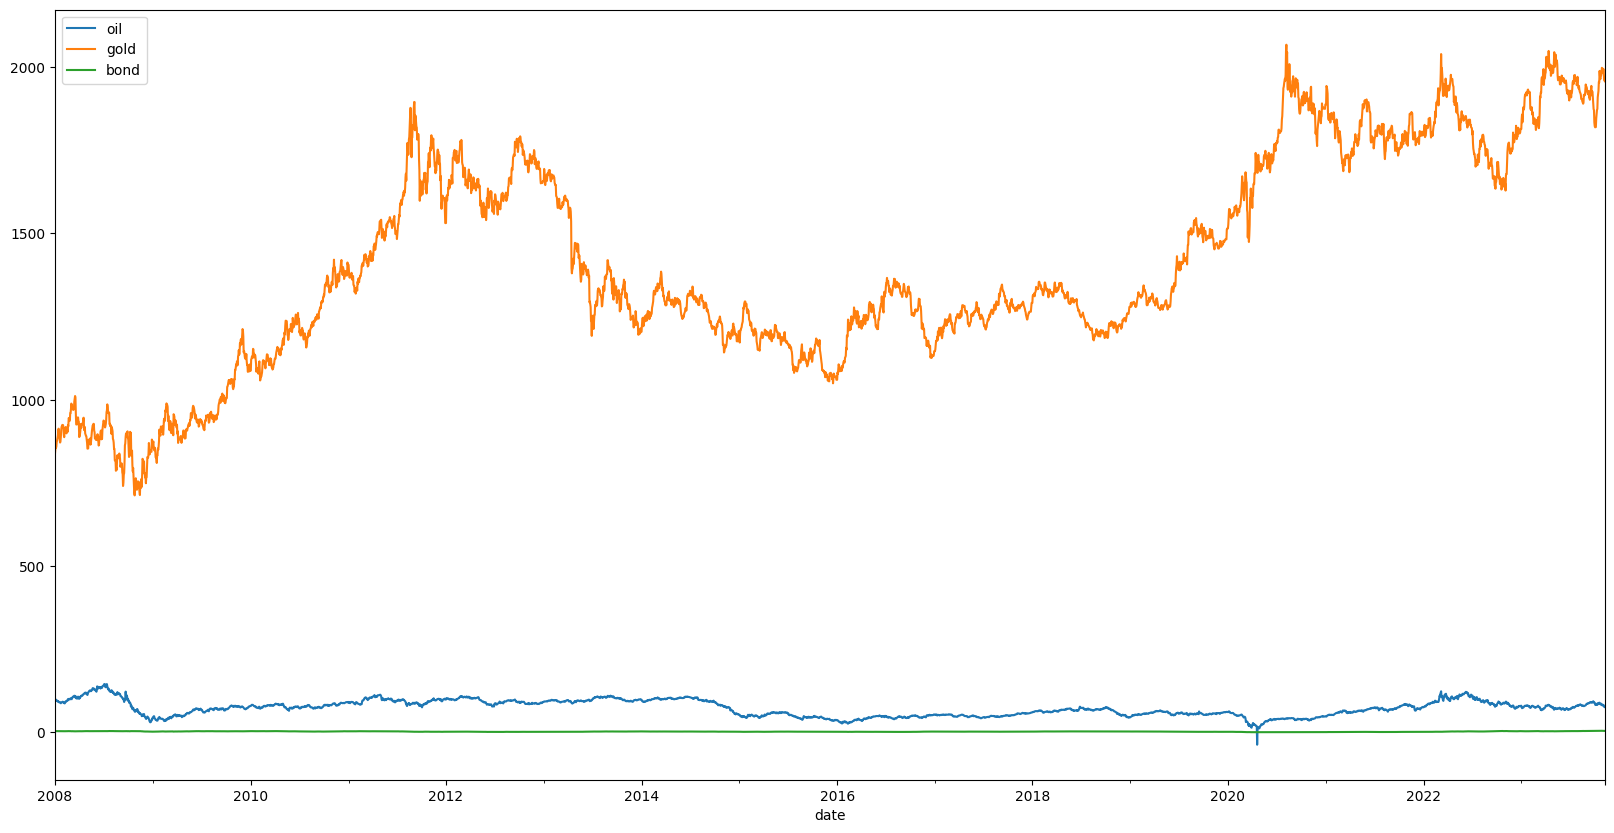

In [17]:
df.plot(x='date', y=['oil', 'gold', 'bond'], figsize=(20,10))

# Johannsen test

In [98]:
result = coint_johansen(df_diff, det_order=1, k_ar_diff=1)

print("eigenvalues")
print("stat:", result.max_eig_stat)
print("crite vals (95%):", result.max_eig_stat_crit_vals[1])

print("\ntrace statistic")
print("stat:", result.trace_stat)
print("crite vals (95%):", result.trace_stat_crit_vals[1])

eigenvalues
stat: [2266.26980275 1895.03648422 1690.36030256]
crite vals (95%): [15.0006 17.1481 21.7465]

trace statistic
stat: [5851.66658953 3585.39678678 1690.36030256]
crite vals (95%): [16.1619 18.3985 23.1485]


In [103]:
# Rank
rank = result.lr1.shape[0]  
rank

3

In [106]:
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.vecm import *
import pandas

ModuleNotFoundError: No module named 'statsmodels.tsa.vecm'